# Clustering con K-Means

## Introducción

El problema de clustering consiste en encontrar una forma de agrupar datos por similaridad.

Vamos arrancar con una pregunta:

¿Que diferencia hay con un problema de clasificación?

¿Se les ocurre algún problema de clasificación que podrian también hacerlo con clustering o por lo menos verlo desde esta perspectiva?

### Métricas

Dado que el objetivo del clustering es encontrar grupos de datos similares entre sí, los resultados dependerán fuertemente de cómo midamos dicha similitud. Es decir, de la métrica que usemos para medir distancias en el espacio generado por nuestras features.

Una métrica muy usada normalente es la métrica de Minkowski, en donde dado un parámetro $p$, la distancia entre dos puntos es

\begin{equation}
d_n(\vec{x_i},\vec{x_j})=\left( \sum_{k=1}^d \vert x_{ik}-x_{jk}\vert^{n}\right)^{\frac{1}{n}}
\end{equation}

en donde $\vec{x_i}$ es el dato i-ésimo representado como un vector de $d$ dimensiones (features). Cuando el parámetro es $n=2$ tenemos la distancia euclídea, que es la que se usa por defecto en la mayoría de los casos. Si $n=1$ define la distancia de Manhattan.

</br>

### Silhouette score

El [score Silhouette](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)  mide cuán cercano es un punto al resto de los que están en su mismo cluster, en relación a cuán cercano es a los puntos del cluster más próximo. Es decir que para cada punto $i$, se tiene un coeficiente $s_i$

$$
s_i=\frac{b(i)-a(i)}{max\{a(i),b(i)\}}
$$

en donde $a(i)$ es la distancia promedio a todos los otros puntos dentro del mismo cluster y $b(i)$ es la distancia promedio a todos los puntos del cluster vecino más cercano. De esta manera

$$
-1\le s_i \le 1
$$

Si $s$ es cercano a 1, significa que el punto $i$ está correctamente etiquetado; $s$ cercano a cero indica que estaría igual de bien (o mal) etiquetarlo con el cluster vecino más cercano y $s$ cercano a -1 significa que el punto $i$ está mal etiquetado y pertenece al cluster vecino.

Para obtener un score del clustering podemos promediar los coeficientes:

$$
S(C)=\frac{1}{k}\sum_{j=1}^k \bar{s}_j
$$

en donde $\bar{s}_j$ es el coeficiente promedio de todos los puntos dentro del cluster j-ésimo.

</br>

### Calinski-Harabasz score

Otra métrica para evaluar la calidad del clustering es el [score Calinski-Harabasz](https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index) que mide la relación entre la dispersión inter-clusters y la dispersión extra-clusters.

Matemáticamente se define así:

$$
s(k)=\frac{Tr(B_k)}{Tr(W_k)}\frac{N-k}{k-1}
$$

en donde $Tr(B_k)$ y $Tr(W_k)$ son las trazas de las matrices de dispersión entre clusters $B_k$ e intra clusters $Tr(W_k)$.

</br>

Si tenemos una buena estructura de clusters con una buena definición daría una **baja dispersión dentro de cada cluster** y una **alta dispersión entre clusters diferentes**. El factor $\frac{Tr(B_k)}{Tr(W_k)}$ tiende a aumentar con el número de clusters, puesto que al aumentar k estamos generando clusters más chicos y por ende menos dispersos. El segundo factor $\frac{N-k}{k-1}$ busca controlar este efecto: tiende a cero cuando k tiende a N.

</br>

### Normalización

Ojo! Como los métodos de clustering dependen de una medida de distancia en el espacio de las features, es muy importante que las mismas se encuentren en la misma escala. Por lo que no debemos de olvidarnos de normalizar los datos.

</br>
</br>


## K-means

K-means es uno de los algoritmos más famosos para la identificación de clusters, por su simplicidad y eficiencia.

Como vimos en la teoría, la idea es poder encontrar los mejores centroides para nuestro espacio de features.

#### Veamos un ejemplo tipico

Trabajaremos con un dataset tomado de Kaggle [Shopping](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python). Veamos que nos dice Kaggle de este dataset:

<b>Contexto</b>

Este conjunto de datos se ha creado únicamente para el aprendizaje de los conceptos de segmentación de clientes, también conocido como análisis de la cesta de la compra (carrito).


<b>Contenido</b>

Usted es propietario de un supermercado y a través de las tarjetas de socio, tiene algunos datos básicos sobre sus clientes como la identificación del cliente, la edad, el género, los ingresos anuales y la puntuación de gasto.
La puntuación de gasto es algo que se asigna al cliente en función de los parámetros definidos, como el comportamiento del cliente y los datos de compra.

<b>Planteamiento del problema</b>

Usted es el propietario del centro comercial y quiere entender a los clientes que pueden ser fácilmente segmentados para que se puede dar al equipo de marketing y planificar la estrategia en consecuencia.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score,silhouette_samples

In [ ]:
path="https://www.dropbox.com/s/zy9k5bekzr16ovr/mall_customers.csv?dl=1"

In [ ]:
df=pd.read_csv(path)
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Renombremos las últimas dos columnas que tienen esos caracteres molestos.

In [ ]:
df.rename({'Annual Income (k$)':'Inc','Spending Score (1-100)':'SS'}, axis=1, inplace=True)
df.head(5)

,CustomerID,Gender,Age,Inc,SS
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


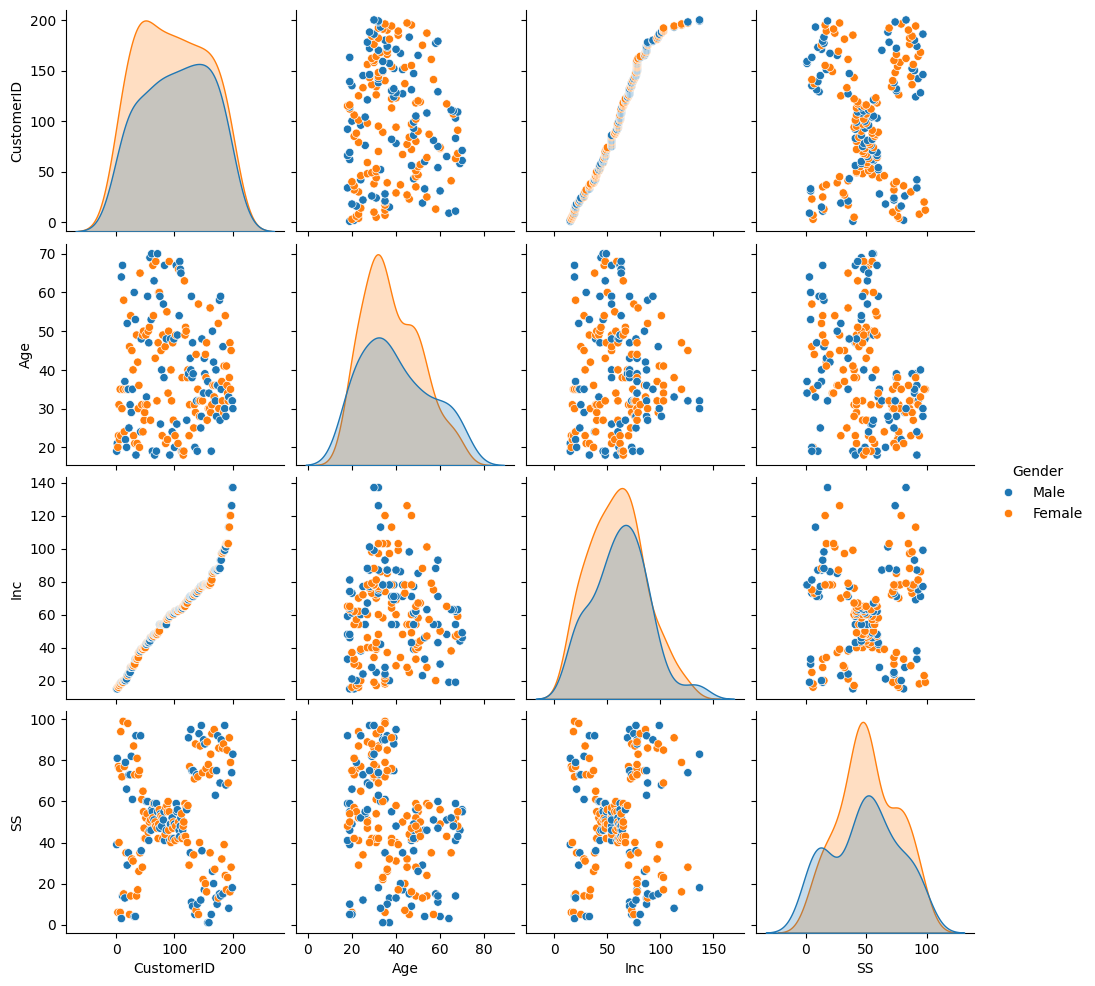

In [ ]:
sns.pairplot(df, hue='Gender');

<b>¿ Qué se puede observar ?</b>

Antes:
    Inc  SS
0   15  39
1   15  81
2   16   6
3   16  77
4   17  40 

Escalado:
 [[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]] 



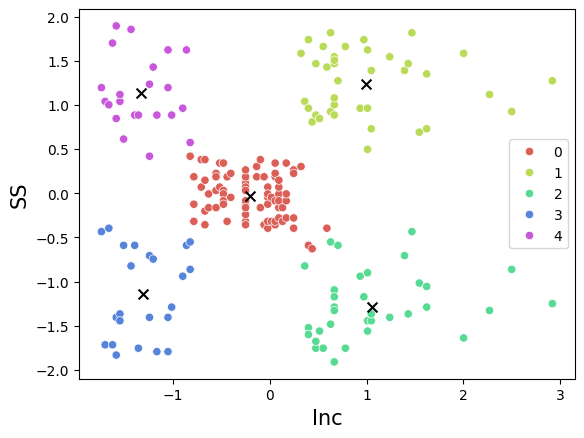

In [ ]:
X = df[['Inc','SS']] # nuevo dataframe con los features 'Inc' y 'SS'

# preprocesamiento: escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Antes:\n', X[:5], '\n')
print('Escalado:\n', X_scaled[:5], '\n')

# clustering con K-means (5 clusters)
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X_scaled)

labels = kmeans.labels_             # Etiquetas
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=labels, legend='full', palette=sns.color_palette("hls", 5))
plt.xlabel('Inc', fontsize=15)
plt.ylabel('SS', fontsize=15)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=50,color='k')

Text(0, 0.5, 'SS')

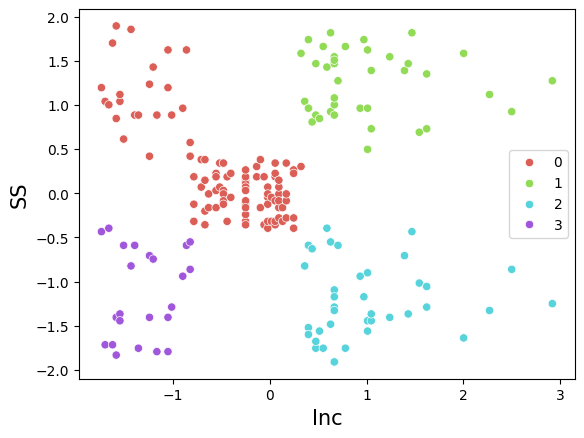

In [ ]:
X = df[['Inc','SS']] # nuevo dataframe con los features 'Inc' y 'SS'

# preprocesamiento: escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# clustering con K-means (4 clusters)
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_scaled)

labels = kmeans.labels_             # Etiquetas
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, legend='full', palette=sns.color_palette("hls", 4))
plt.xlabel('Inc', fontsize=15)
plt.ylabel('SS', fontsize=15)

### ¿Cómo elegir K y cómo hacer una evaluación del modelo?

En algunos problemas uno conoce a priori el número de clusters que busca. Pero normalmente uno no sabe cual es ese número k.

En el ejemplo de los consumidores pudimos ver a ojo que  más o menos el número de clusters que buscábamos era 5. Esto fue posible al visualizar los datos en dos dimensiones, pero como vimos en clases anteriores esto casí nunca se puede hacer.

Veremos a continuación algunas estrategias para elegir el valor de k y evaluar el modelo de clustering.

En primer lugar podríamos usar como métrica la suma de las distancias cuadráticas de los puntos a sus centroides. Esto constituiría una medida de error, ya que uno desearía que los puntos estén cerca del centroide de su cluster.

</br>

<b>¿Qué se espera que pase con esta métrica a medida que aumentamos k?</b>

El atributo 'inertia_' del modelo kmeans tiene precisamente dicha suma de distancias cuadráticas a los centroides.

Veamos cómo varía con los distintos valores de k ...


Text(0, 0.5, 'Suma Distancias Cuadráticas')

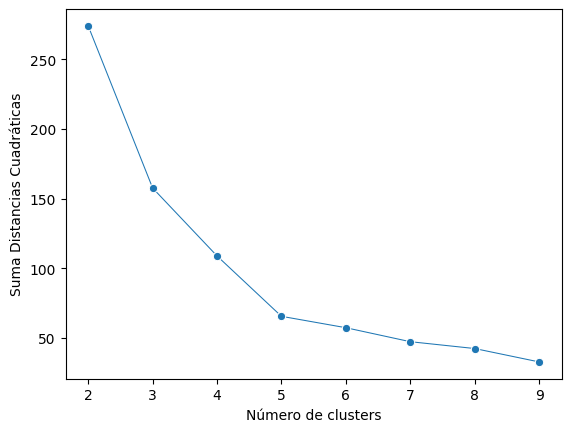

In [ ]:
k_values = range(2,10);
sq_distances = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values, y=sq_distances, marker='o', size=30, legend=False)
plt.xlabel('Número de clusters')
plt.ylabel('Suma Distancias Cuadráticas')

A medida que aumentamos el número de clusters, la suma de distancias cuadráticas se achica. Evidentemente, si k fuera igual a n, habría un centroide para cada punto y las distancias serían todas iguales a cero.

Un criterio para elegir el k es utilizar la regla heurística "del codo", en donde se elige el k a partir del cual la curva se empieza a aplanar. Es decir, a partir del cual la incorporación de un nuevo cluster no explica mucha más varianza de los datos. En este caso se ve que k=5 es una buena opción.



Grafiquemos el ahora el silhouette score en función de k en nuestro dataset:

Text(0.5, 0, 'Número de clusters')

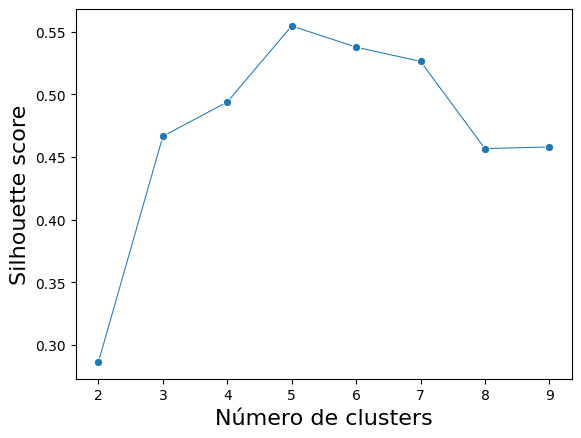

In [ ]:
k_values = range(2,10)
sil = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0) # 10 repeticiones
    kmeans.fit(X_scaled)

    score = silhouette_score(X_scaled, kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values, y=sil, marker='o', size=33, legend=False)
plt.ylabel('Silhouette score', fontsize=16)
plt.xlabel('Número de clusters', fontsize=16)

Este plot nos muestra que el silhouette score promedio para cada valor de k, y nuevamente vemos que el valor óptimo es $k=5$.

</br>

Veamos la métrica que nos queda, la de Caliski-Harabasz, dependiendo de los datos puede ser que tengamos un pico bien definido que nos permita elegir el k, o puede ser que para valores razonable de k el score sea creciente pero podamos usar otro criterio como la "regla del codo" para ayudarnos.


Text(0.5, 0, 'Número de clusters')

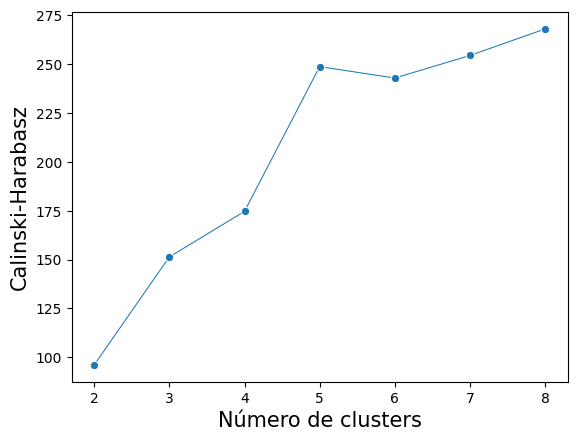

In [ ]:
from sklearn.metrics import calinski_harabasz_score

k_values = range(2,9)
ch_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0) # 10 repeticiones
    kmeans.fit(X_scaled)

    score = calinski_harabasz_score(X_scaled, kmeans.labels_)
    ch_scores.append(score)

sns.lineplot(x=k_values, y=ch_scores, marker='o', size=30, legend=False);
plt.ylabel('Calinski-Harabasz', fontsize=15)
plt.xlabel('Número de clusters', fontsize=15)

# Ejemplos ...

## K-modes (para variables categóricas)

`K-means` tiene sentido cuando las variables son continuas. Si tuvieramos alguna variable categórica podríamos incluirla en el análisis creando las variables dummy (one-hot-encoding) correspondientes y estandarizándolas. Pero si todos los datos fueran categóricos tendriamos que cambiar de algoritmo.

`K-modes` es una modificación muy intuitiva, en donde los centroides están definidos por las modas (valor más frecuente) de cada feature, medidas sobre los puntos que forman cada cluster. La distancia entre dos puntos, en lugar de ser la euclídea, se define como el número de features en los cuales no coinciden los valores.

Pueden ver un ejemplo acá :

https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering





## Silhouette Score

Fuente https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

El análisis de silueta se puede utilizar para estudiar la distancia de separación entre los clústeres resultantes.

El gráfico de silueta muestra una medida de la proximidad de cada punto de un clúster a los puntos de los clústeres vecinos y, por lo tanto, proporciona una forma de evaluar visualmente parámetros como la cantidad de clústeres. Esta medida tiene un rango de [-1, 1].

Los coeficientes de silueta (como se denominan estos valores) cercanos a +1 indican que la muestra está lejos de los clústeres vecinos. Un valor de 0 indica que la muestra está en el límite de decisión entre dos clústeres vecinos o muy cerca de él y los valores negativos indican que esas muestras podrían haber sido asignadas al clúster incorrecto.


For 2 clusters the average silhouette_score is: 0.7049787496083262
For 3 clusters the average silhouette_score is: 0.5882004012129721
For 4 clusters the average silhouette_score is: 0.6505186632729437
For 5 clusters the average silhouette_score is: 0.561464362648773
For 6 clusters the average silhouette_score is: 0.4857596147013469


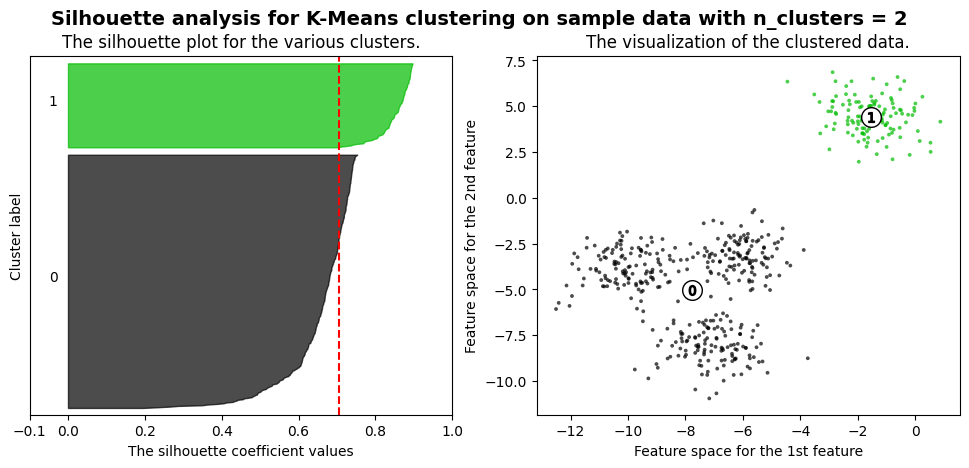

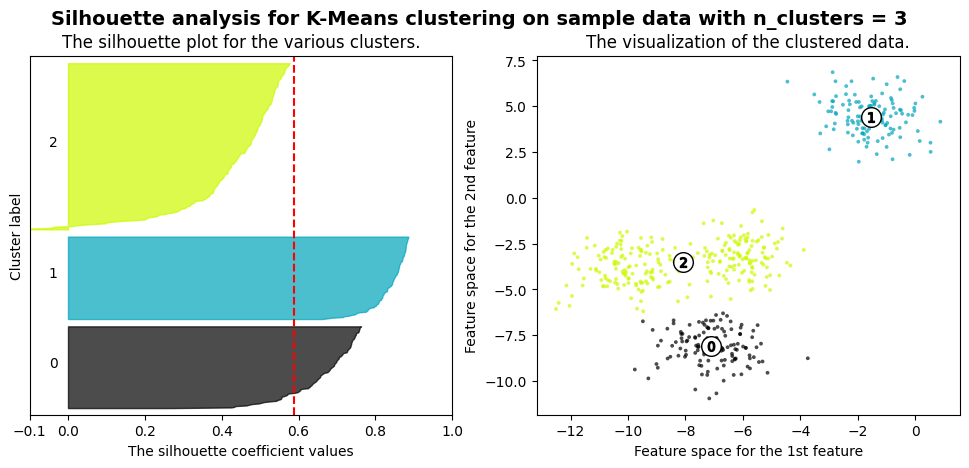

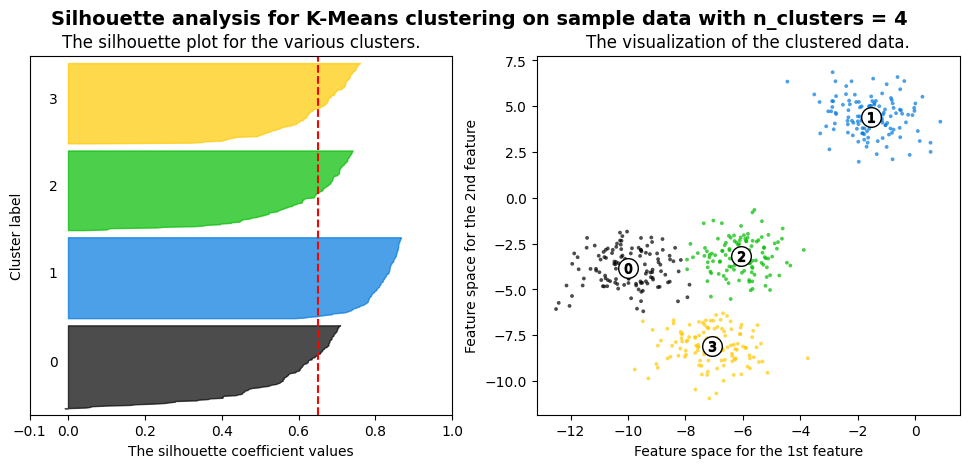

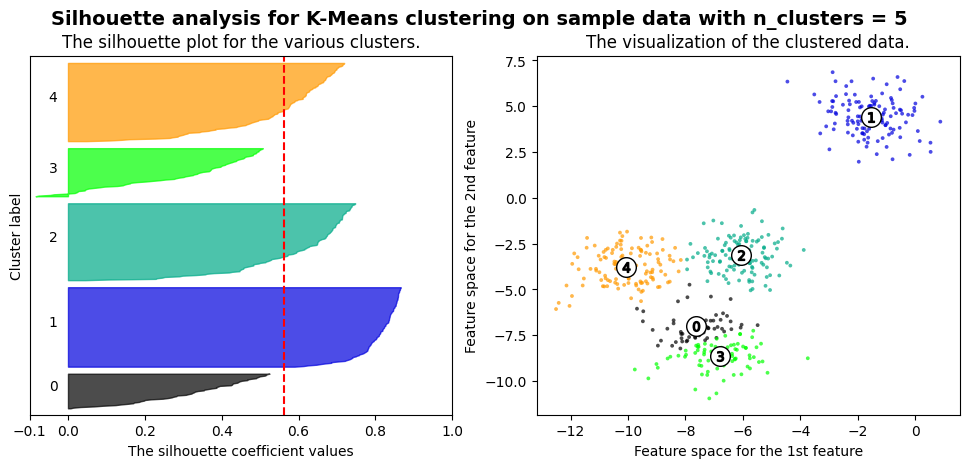

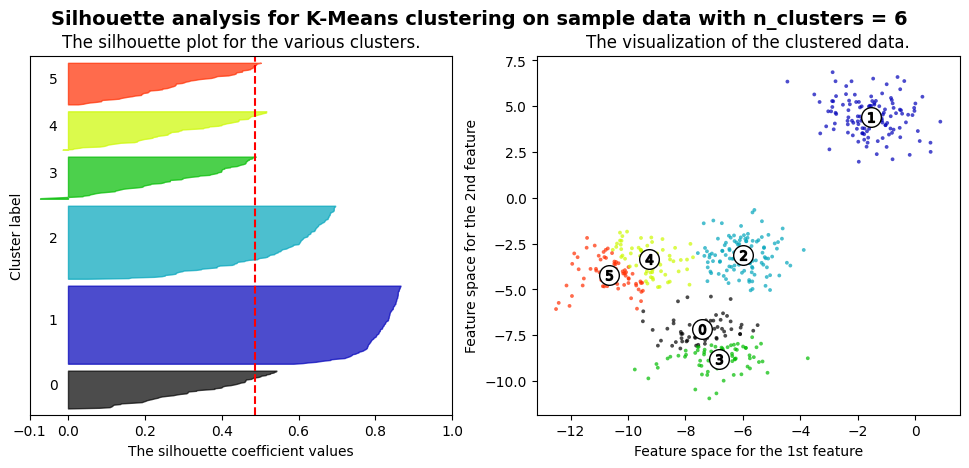

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1, # for reproducibility
)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4.66)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1 to 1, but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])

    # The (n_clusters + 1) *10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10) # seed of 10 for reproducibility
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For", n_clusters, "clusters the average silhouette_score is:", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color, edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        s=200,
        c="white", edgecolor="k", alpha=1
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for K-Means clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14, fontweight="bold"
    )

plt.show()


En este ejemplo, el análisis de silueta se utiliza para elegir un valor óptimo para n_clusters.

El gráfico de silueta muestra que los valores de n_clusters de 3, 5 y 6 son una mala elección para los datos dados, debido a la presencia de clústeres con puntajes de silueta por debajo del promedio y también debido a las amplias fluctuaciones en el tamaño de los gráficos de silueta. El análisis de siluetas es más ambivalente a la hora de decidir entre 2 y 4.

También se puede visualizar el tamaño del conglomerado a partir del grosor del gráfico de siluetas.

El gráfico de siluetas para el conglomerado 0 cuando n_clusters es igual a 2, es más grande debido a la agrupación de los 3 subconglomerados en un gran conglomerado. Sin embargo, cuando n_clusters es igual a 4, todos los gráficos tienen un grosor más o menos similar y, por lo tanto, tamaños similares, como también se puede verificar a partir del gráfico de dispersión etiquetado a la derecha.

## Clustering para comprimir imagenes

Fuente

https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

## DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de aprendizaje no supervisado utilizado para el análisis de datos y la agrupación de puntos en clusters. A diferencia de otros algoritmos como K-Means, DBSCAN no requiere especificar el número de clusters de antemano y es capaz de identificar clusters de forma arbitraria, lo que lo hace útil para datos de forma irregular.

### Funcionamiento:
DBSCAN se basa en dos parámetros clave:
1. **`eps` (epsilon):** El radio máximo que define el vecindario de un punto.
2. **`min_samples`:** El número mínimo de puntos que debe tener un vecindario para que un punto se considere un "punto central" de un cluster.

### Pasos:
1. **Punto central:** Si un punto tiene al menos `min_samples` puntos en su radio `eps`, se considera un punto central.
2. **Expansión del cluster:** Se agrupan los puntos vecinos de un punto central, formando un cluster.
3. **Punto frontera:** Los puntos que están dentro de `eps` de un punto central pero no tienen suficientes vecinos por sí mismos se consideran puntos frontera.
4. **Ruido:** Los puntos que no son ni puntos centrales ni frontera son clasificados como ruido.

### Ventajas:
- No requiere el número de clusters como entrada.
- Puede identificar clusters de cualquier forma.
- Es robusto frente a ruido (outliers).

### Desventajas:
- Puede fallar cuando los clusters tienen densidades muy variables.
- La elección de los parámetros `eps` y `min_samples` puede ser crítica y sensible.

### Ejemplo en Python con `sklearn`:

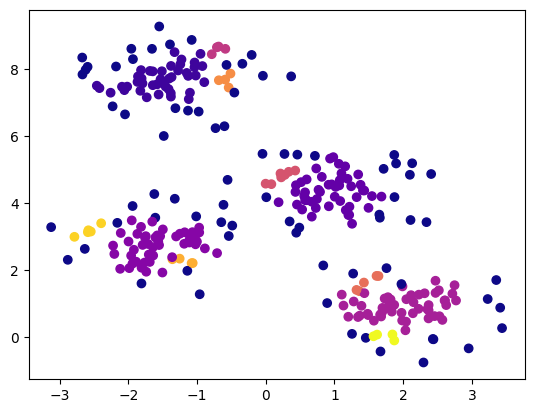

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generar datos de ejemplo
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(X)

# Visualizar clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='plasma')
plt.show()

In [ ]:
labels    # los puntos clasificados como -1 son outliers

array([-1,  0,  1,  0, -1, -1, -1,  1, -1,  4,  2, -1,  1, -1, -1,  1,  1,
        3,  2,  8,  3,  3,  1,  2,  2, -1,  3,  1, -1,  1,  7,  0, -1, -1,
        0,  0,  0, -1,  2,  3,  1,  2, -1,  1,  2,  2,  0,  2,  0,  3,  2,
        3,  0,  3, -1,  2, -1, -1,  0,  3,  0,  1, -1,  2,  2,  2,  0,  3,
       -1,  2,  1, -1,  0,  2,  2,  4,  2,  1,  3,  0, -1,  1,  3,  3,  0,
        1,  3,  5, -1,  0,  1,  3, -1,  2,  2,  1,  6,  3, -1, -1,  4, -1,
        7,  3,  1,  3, -1,  1, -1,  1,  8, -1,  3, -1,  3, -1,  0,  3,  6,
       -1, -1,  3, -1,  3,  6,  3,  3,  8,  3,  2, -1,  2,  2, -1,  0,  8,
        9,  0, -1,  7, -1,  2,  1, -1, -1,  2,  0, -1,  0,  0,  0,  1, -1,
        5, 10,  2,  0,  2,  3,  1, -1,  1,  1,  6,  1, -1, -1,  5,  3,  1,
        1,  0,  3, -1, -1,  0,  3,  3,  1,  2,  3,  1,  2,  2,  5,  1,  1,
        1,  3,  0, -1,  2,  1,  1,  2,  2,  9, -1,  2,  0,  1,  2, 10,  2,
        1, -1,  2,  4,  1, -1,  1,  2,  5, -1,  0,  2,  2,  3, -1,  1,  0,
        3,  3,  9, 10,  9